# KORONAVIRUS

U jeku nove epidemije naše su misli cijeli dan, svaki dan, usmjerene na nove vijesti o stanju u državi i svijetu, broju zaraženih, oporavljenih i preminulih od nove bolesti. Budući da su svi ti podatci danas lako dostupni (a medicina je iznimno zanimljiva za proučavanje s matematičke točke gledišta), u ovom ćemo radu promatrati i analizirati te podatke.

## Što je koronavirus?

Par činjenica unijeti, ne previše, ali ipak da znamo što je.

## Analiza podataka

Podatci su preuzeti sa stranice https://data.europa.eu/euodp/hr/data/dataset/covid-19-coronavirus-data i spremljeni u datoteku (zasad) `preuzmi.csv`. <br><br>
Atributi podataka su sljedeći:<br><br>
```
    1. dateRep = promatrani datum u formatu 'dd/mm/gggg'
    2. day = broj dana u promatranom datumu
    3. month = broj mjeseca u promatranom datumu
    4. year = broj godine u promatranom datumu
    5. cases = broj novozaraženih na promatrani dan
    5. deaths = broj preminulih na promatrani dan
    6. countriesAndTerritories = naziv države
    7. geoId = iso kod države (alpha 2)
    8. countryterritoryCode = iso kod države (alpha 3)
    9. popData2018 = ukupan broj populacije iz 2018. za promatranu državu
```
<br>
Prije nego što krenemo prikazivati tablice i analizirati podatke, prvo želimo tablicu <i>srediti</i>. Vidimo odmah da u ovoj tablici ima redundancija (datumi) i nama nebitnih podataka (iso kodovi) pa ćemo prije svega uključiti potrebne biblioteke i riješiti se tih problema.

In [1]:
import numpy as np
import pandas as pd
import datetime as dtt

def izdvoji_drzavu(drzava):
    return data[data['Country'] == drzava]
#nije potrebno pisati ovu funkciju, ali s njom ne moramo konstantno pisati istu, iscrpljujuće dugu liniju koda

data = pd.read_csv('preuzmi.csv', encoding='utf-8')
data = data.rename(columns={'dateRep': 'Date', 'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories': 'Country', 'popData2018': 'Population'})

dani = np.array(izdvoji_drzavu('China')['day'])[::-1]
mjeseci = np.array(izdvoji_drzavu('China')['month'])[::-1]
godine = np.array(izdvoji_drzavu('China')['year'])[::-1]
datumi = np.array(izdvoji_drzavu('China')['Date'])[::-1]
dat_rj = {}
for i in range(0, dani.shape[0]):
    dat_rj[datumi[i]] = dtt.datetime(godine[i], mjeseci[i], dani[i])
data.replace({'Date': dat_rj}, inplace = True)
del data['day'], data['month'], data['year'], data['geoId'], data['countryterritoryCode']

In [2]:
data.head()

,Date,Cases,Deaths,Country,Population
0,2020-04-11,37,0,Afghanistan,37172386.0
1,2020-04-10,61,1,Afghanistan,37172386.0
2,2020-04-09,56,3,Afghanistan,37172386.0
3,2020-04-08,30,4,Afghanistan,37172386.0
4,2020-04-07,38,0,Afghanistan,37172386.0


Sad možemo pogledati grafički prikaz razvoja epidemije.<br>
Prije svega ćemo prikazati kretanje broja zaraženih:

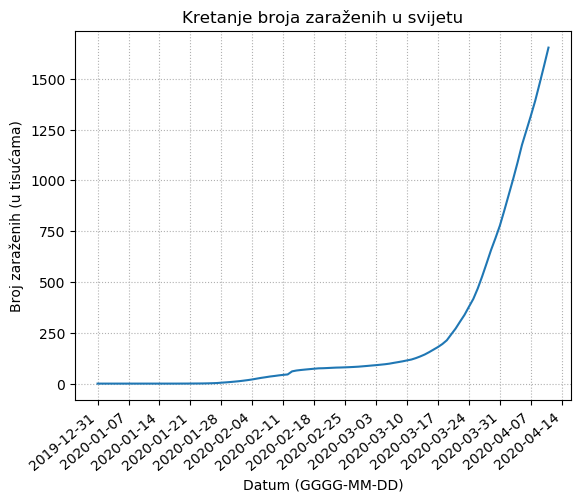

In [70]:
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 50
%matplotlib agg

def ukupno_dnevno_stanje(argument):
    lista=[]
    suma = 0
    for datum in izdvoji_drzavu('China')['Date'][::-1]:
        for broj in data[data['Date']==datum][argument]:
            suma += broj
        lista.append(suma)
    return lista

def pokazi_stanje_u_svijetu(argument):
    base =dtt.datetime(2019, 12, 31)
    dates2 = np.array([base + dtt.timedelta(days = i*7) for i in range (0, 16)])
    fig, ax = plt.subplots()
    ax.plot(np.array(izdvoji_drzavu('China')['Date'])[::-1], np.array(ukupno_dnevno_stanje(argument))/1000)
    if (argument == 'Cases'):
        ax.set_title('Kretanje broja zaraženih u svijetu')
        ax.set_ylabel('Broj zaraženih (u tisućama)')
    elif (argument == 'Deaths'):
        ax.set_title('Kretanje broja preminulih u svijetu')
        ax.set_ylabel('Broj preminulih (u tisućama)')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(dates2)
    plt.grid(linestyle = ':')
    return fig

pokazi_stanje_u_svijetu('Cases')

Safa pogledajmo i kretanje broja preminulih:

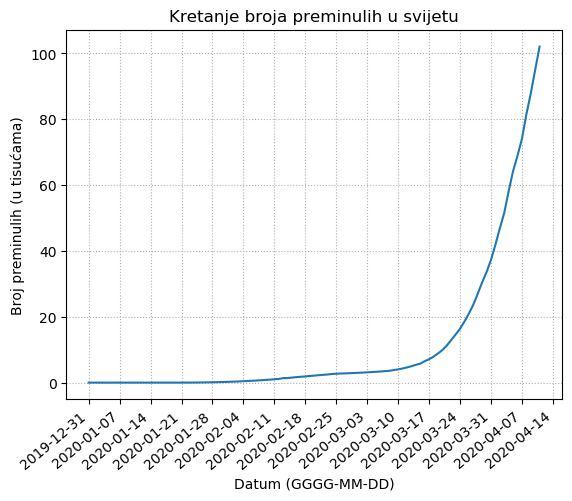

In [71]:
pokazi_stanje_u_svijetu('Deaths')

Želimo (uredno) prikazati kretanje broja zaraženih i preminulih od virusa.

In [72]:
def lista_dnevno_stanje(drzava, argument):
    lista = []
    i=-1
    for dnevno_stanje in np.array(izdvoji_drzavu(drzava)[argument])[::-1]:
        if (i==-1): lista.append(int(dnevno_stanje))
        else: lista.append(int(dnevno_stanje)+lista[i])
        i +=1
    return lista
#pomoćna funkcija koja nam vraća listu podataka
        #naime, zgodna nam je, jer se u našoj tablici data u stupcu Cases nalaze podatci o broju novozaraženih toga dana
        #a mi želimo pratiti kontinuirani rast

def prikaz_kontinuiranog_stanja(drzava, argument):
    dates = np.array(izdvoji_drzavu(drzava)['Date'])[::-1]
    i = 0
    while(np.array(izdvoji_drzavu(drzava)[izdvoji_drzavu(drzava)['Date']==dates[i]][argument])[0]==0): i += 1
    if (i > 2): i -= 2
    #ne želimo imati puno 'nula', pa zato krećemo prikazivati podatke od par dana prije pojave prvog oboljelog
    n = dates[i:].shape[0]//10
    base = dates[i]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    #također ne želimo da nam se prikaže apsolutno svaki datum jer je to nepregledno
    fig, ax = plt.subplots()
    ax.plot(dates[i:], lista_dnevno_stanje(drzava, argument)[i:])
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(dates2)
    if (argument == 'Cases'):
        ax.set_title('Kretanje broja zaraženih u državi: ' + drzava)
        ax.set_ylabel('Broj zaraženih')
    elif (argument == 'Deaths'):
        ax.set_title('Kretanje broja preminulih u državi: ' + drzava)
        ax.set_ylabel('Broj preminulih')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    plt.grid(linestyle = ':')
    return fig

Za primjer, evo grafičkog prikaza podataka u SAD-u:

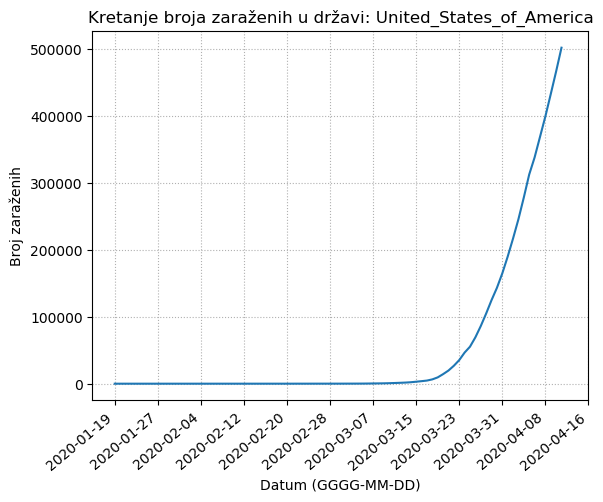

In [74]:
prikaz_kontinuiranog_stanja('United_States_of_America', 'Cases')

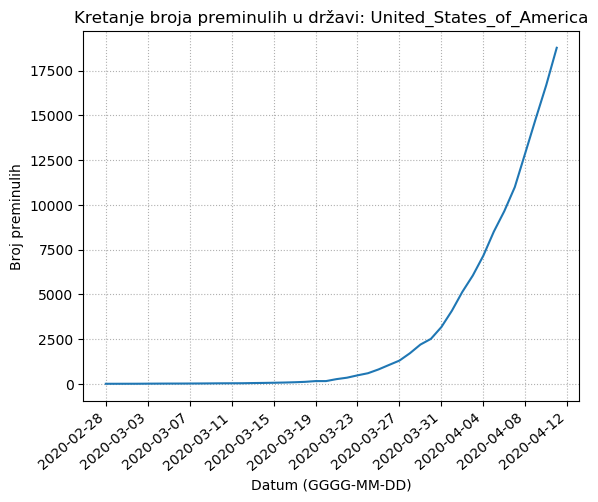

In [75]:
prikaz_kontinuiranog_stanja('United_States_of_America', 'Deaths')

Također nam je korisno uspoređivati podatke u raznim državama:

In [66]:
def pripremi_podatke(drzava, argument):
    dates = np.array(izdvoji_drzavu(drzava)['Date'])[::-1]
    n = dates.shape[0]//10
    base = dates[0]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    return [dates, dates2]
#još jedna pomoćna funkcija za bolju organizaciju podataka

def usporedba(lista, argument):
    brojevi = np.array([izdvoji_drzavu(drzava)[izdvoji_drzavu(drzava)['Cases']>=0].shape[0] for drzava in lista])
    broj = brojevi.max()
    i = 0
    for temp in brojevi:
        if (broj == temp): break;
        i += 1
    datumi = pripremi_podatke(lista[i], argument)
    fig, ax = plt.subplots()
    duljina = datumi[0].shape[0]
    for j in range (0, len(lista)):
        nova = lista_dnevno_stanje(lista[j], argument)[::-1]
        while (len(nova) < duljina): nova.append(0)
        ax.plot(datumi[0], nova[::-1]/(np.array(izdvoji_drzavu(lista[j])['Population'])[0]/100), label = lista[j])
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(datumi[1])
    ax.legend(loc = 'best')
    if (argument == 'Cases'): 
        ax.set_title('Usporedba kretanja broja zaraženih')
        ax.set_ylabel('Udio zaraženih (%)')
    elif (argument == 'Deaths'): 
        ax.set_title('Usporedba kretanja broja preminulih')
        ax.set_ylabel('Udio preminulih (%)')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    plt.grid(linestyle = ':')
    return fig

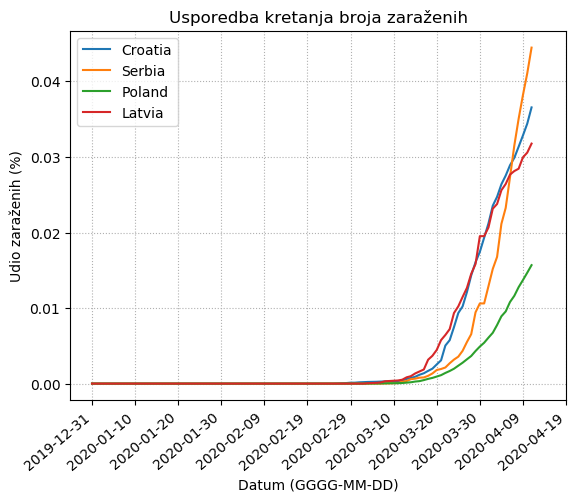

In [67]:
usporedba(['Croatia', 'Serbia', 'Poland', 'Latvia'], 'Cases')

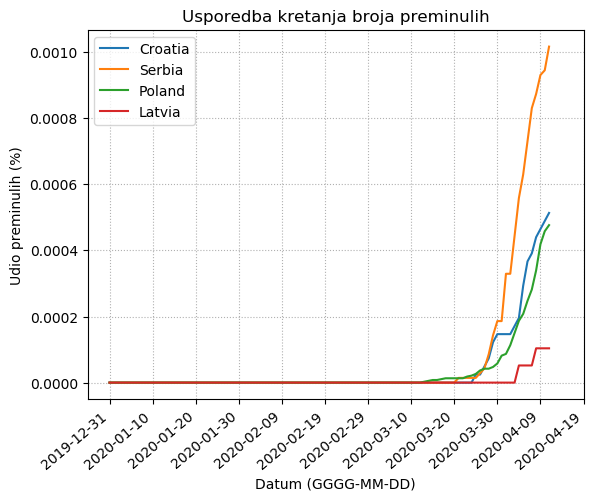

In [77]:
usporedba(['Croatia', 'Serbia', 'Poland', 'Latvia'], 'Deaths')

Naravno, nas ne zanima isključivo trenutno stanje, već nas zanima možemo li <i>predvidjeti</i> daljnji tijek ove epidemije?<br>
Odgovor: <b>linearna regresija</b>.<br><br>
<i>Slijedi pojašnjenje što je točno linearna regresija, nadodat ću naknadno...</i><br><br>
Maločas navedenom metodom možemo procijeniti mogući tijek epidemije (na primjer, za Hrvatsku): <br><br>
<i>(uz napomenu da podatci nisu definitivni jer će eventualno doći do usporavanja rasta oboljelih; tu je moguće pričati o epidmiološkim modelima: SIS ili SIR (koliko sam zasad informiran, nije još sigurno stječe li se imunitet)</i>

In [83]:
import statsmodels.api as sm

def pomocni_ln(broj):
    if (broj == 0): return 0
    else: return float(np.log(broj))

lnn = np.vectorize(pomocni_ln, otypes=[np.float])

def vrati_procjenu(a, b):
    return lambda x: (np.e**a)*((np.e**b)**x)

def linearna_regresija(drzava):
    broj_dana = np.array(izdvoji_drzavu(drzava)['Date'].drop_duplicates()).shape[0]
    brojac_dana = [i for i in range(0, broj_dana)]
    brojac_dana = sm.add_constant(brojac_dana)
    zaraza = lnn(np.array(lista_dnevno_stanje(drzava, 'Cases')))
    model = sm.OLS(zaraza, brojac_dana)
    rez = model.fit()
    print(rez.summary())
    return vrati_procjenu(rez.params[0], rez.params[1])

In [84]:
funkcija = linearna_regresija('Croatia')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     317.0
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           1.78e-32
Time:                        00:41:17   Log-Likelihood:                -168.86
No. Observations:                 100   AIC:                             341.7
Df Residuals:                      98   BIC:                             346.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0537      0.263     -7.821      0.0

In [88]:
funkcija(120)

2291.0960154638665

<b>NAPOMENE I IDEJE</b>:<br><br>
<lu>
    <li>Paziti da ovo doista bude priča, a ne samo crtanje lijepih grafova u raznim bojama!</li>
    <li>Bilo bi zgodno prilagoditi dosadašnje funkcije tako da nemamo razdvojeni prikaz broja zaraženih i preminulih nego da ta dva grafa budu <i>side-by-side</i>.</li>
    <li>Prikaz dnevnih brojki prebaciti u histogram.</li>
    <li>Možda kakav 3D graf? Ili animacija? </li>
    <li>Poseban fokus staviti na Hrvatsku i njezine brojke. Prikupiti dodatne brojke iz svoje tablice (tj. stranice koronavirus.hr) i prikazati ih.</li>
    <li><b>Primjeniti linearnu regresiju.</b> Zapravo, napraviti nešto <i>konkretno</i>: pokušati predvidjeti moguće brojke na temelju dosadašnjih, pogledati moguće modele (SIR, za primjer) i slično. </li>
    <li>Prilagoditi funkciju `linearna_regresija` da ne uzima podatke za svaku državu od 31.12.2019. pa da onda ima dva mjeseca <i>nule</i>, već prilagoditi podatke tome.</li>
</lu>